In [1]:
import sys
sys.path.append("../codes/")
from Readfiles import getFnames
from DCdata import readReservoirDC
%pylab inline

Efficiency Warning: Interpolation will be slow, use setup.py!

            python setup.py build_ext --inplace
    
Populating the interactive namespace from numpy and matplotlib


In [25]:
!pwd

'pwd'은(는) 내부 또는 외부 명령, 실행할 수 있는 프로그램, 또는
배치 파일이 아닙니다.


In [3]:
from SimPEG.EM.Static import DC
from SimPEG import EM
from SimPEG import Mesh

Read DC data

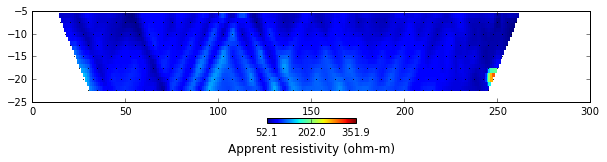

In [4]:
fname = "../data/ChungCheonDC/20150101000000.apr"
survey = readReservoirDC(fname)
dobsAppres = survey.dobs
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dtype='volt', sameratio=False)
cb = dat[2]
cb.set_label("Apprent resistivity (ohm-m)")
geom = np.hstack(dat[3])
dobsDC = dobsAppres * geom 

In [5]:
# problem = DC.Problem2D_CC(mesh)
cs = 2.5
npad = 6
hx = [(cs,npad, -1.3),(cs,160),(cs,npad, 1.3)]
hy = [(cs,npad, -1.3),(cs,20)]
mesh = Mesh.TensorMesh([hx, hy])
mesh = Mesh.TensorMesh([hx, hy],x0=[-mesh.hx[:6].sum()-0.25, -mesh.hy.sum()])

In [6]:
def from3Dto2Dsurvey(survey):
    srcLists2D = []
    nSrc = len(survey.srcList)

    for iSrc in range (nSrc):
        src = survey.srcList[iSrc]
        locsM = np.c_[src.rxList[0].locs[0][:,0], np.ones_like(src.rxList[0].locs[0][:,0])*-0.75] 
        locsN = np.c_[src.rxList[0].locs[1][:,0], np.ones_like(src.rxList[0].locs[1][:,0])*-0.75] 
        rx = DC.Rx.Dipole_ky(locsM, locsN)
        locA = np.r_[src.loc[0][0], -0.75]
        locB = np.r_[src.loc[1][0], -0.75]
        src = DC.Src.Dipole([rx], locA, locB)
        srcLists2D.append(src)
    survey2D = DC.Survey_ky(srcLists2D)
    return survey2D

In [7]:
from SimPEG import (Mesh, Maps, Utils, DataMisfit, Regularization,
                    Optimization, Inversion, InvProblem, Directives)

In [8]:
mapping = Maps.ExpMap(mesh)
survey2D = from3Dto2Dsurvey(survey)
problem = DC.Problem2D_N(mesh, mapping=mapping)
problem.pair(survey2D)
m0 = np.ones(mesh.nC)*np.log(1e-2)

<function __main__.foo>

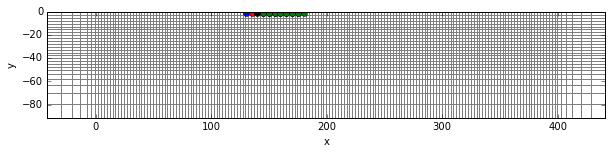

In [9]:
from ipywidgets import interact
nSrc = len(survey2D.srcList)
def foo(isrc):
    figsize(10, 5)
    mesh.plotImage(np.ones(mesh.nC)*np.nan, gridOpts={"color":"k", "alpha":0.5}, grid=True)
#     isrc=0
    src = survey2D.srcList[isrc]
    plt.plot(src.loc[0][0], src.loc[0][1], 'bo')
    plt.plot(src.loc[1][0], src.loc[1][1], 'ro')
    locsM = src.rxList[0].locs[0]
    locsN = src.rxList[0].locs[1]
    plt.plot(locsM[:,0], locsM[:,1], 'ko')
    plt.plot(locsN[:,0], locsN[:,1], 'go')
    plt.gca().set_aspect('equal', adjustable='box')
    
interact(foo, isrc=(0, nSrc-1, 1))

In [10]:
pred = survey2D.dpred(m0)

In [11]:
# data_anal = []
# nSrc = len(survey.srcList)
# for isrc in range(nSrc):
#     src = survey.srcList[isrc]    
#     locA = src.loc[0]
#     locB = src.loc[1]
#     locsM = src.rxList[0].locs[0]
#     locsN = src.rxList[0].locs[1]
#     rxloc=[locsM, locsN]
#     a = EM.Analytics.DCAnalyticHalf(locA, rxloc, 1e-3, earth_type="halfspace")
#     b = EM.Analytics.DCAnalyticHalf(locB, rxloc, 1e-3, earth_type="halfspace")
#     data_anal.append(a-b)
# data_anal = np.hstack(data_anal)

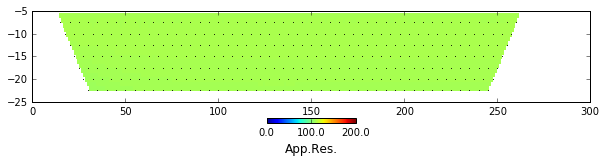

In [12]:
survey.dobs = pred
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dtype='appr', sameratio=False, scale="linear", clim=(0, 200))

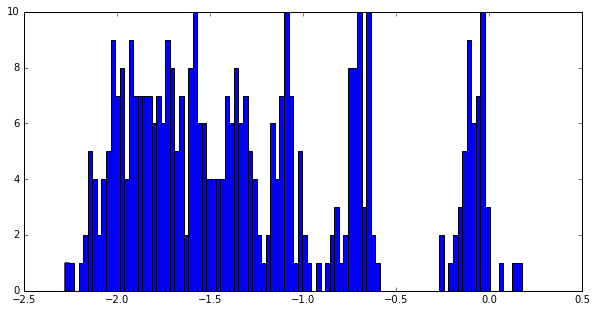

In [13]:
out = hist(np.log10(abs(dobsDC)), bins = 100)

In [14]:
weight =  1./abs(mesh.gridCC[:,1])**1.5

(<matplotlib.collections.QuadMesh at 0xd7cd320>,)

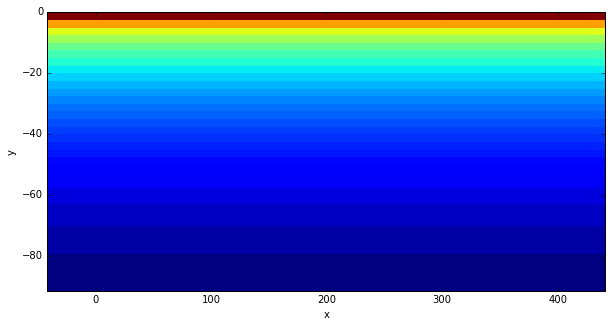

In [15]:
mesh.plotImage(np.log10(weight))

In [16]:
survey2D.dobs = dobsDC
survey2D.eps = 10**(-2.3)
survey2D.std = 0.02
dmisfit = DataMisfit.l2_DataMisfit(survey2D)
regmap = Maps.IdentityMap(nP=int(mesh.nC))
reg = Regularization.Simple(mesh,mapping=regmap,cell_weights=weight)
opt = Optimization.InexactGaussNewton(maxIter=5)
invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
# Create an inversion object
beta = Directives.BetaSchedule(coolingFactor=5, coolingRate=2)
betaest = Directives.BetaEstimate_ByEig(beta0_ratio=1e0)
inv = Inversion.BaseInversion(invProb, directiveList=[beta, betaest])
problem.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
mopt = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  5.06e+02  1.27e+04  0.00e+00  1.27e+04    5.19e+03      0              
   1  5.06e+02  1.33e+03  3.39e+00  3.05e+03    3.69e+02      0              
   2  1.01e+02  1.03e+03  3.87e+00  1.42e+03    8.45e+02      0   Skip BFGS  
   3  1.01e+02  2.21e+02  7.04e+00  9.34e+02    3.98e+01      0              
   4  2.02e+01  2.11e+02  7.11e+00  3.55e+02    2.69e+02      0              
   5  2.02e+01  1.46e+02  8.35e+00  3.15e+02    2.22e+02      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 3.9939e+01 <= tolF*(

In [17]:
xc = opt.recall("xc")

(-10, 290)

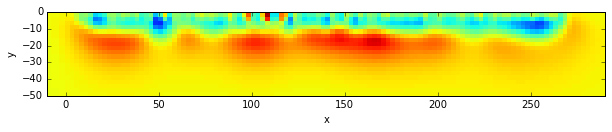

In [18]:
fig, ax = plt.subplots(1,1, figsize = (10, 1.5))
sigma = mapping*mopt
dat = mesh.plotImage(1./sigma, clim=(10, 150),grid=False, ax=ax, pcolorOpts={"cmap":"jet"})
ax.set_ylim(-50, 0)
ax.set_xlim(-10, 290)

In [19]:
print np.log10(sigma).min(), np.log10(sigma).max()

-2.16155569809 -1.52329859013


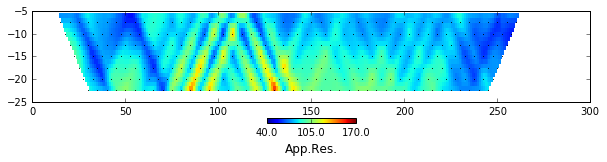

In [20]:
survey.dobs = invProb.dpred
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dtype='appr', sameratio=False, clim=(40, 170))

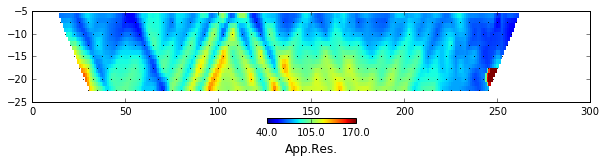

In [21]:
survey.dobs = dobsDC
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dtype='appr', sameratio=False, clim=(40, 170))

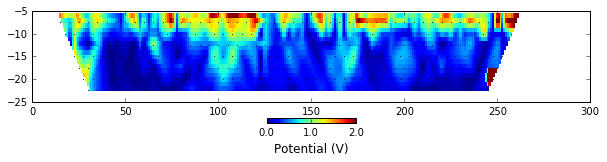

In [22]:
survey.dobs = abs(dmisfit.Wd*(dobsDC-invProb.dpred))
fig, ax = plt.subplots(1,1, figsize = (10, 2))
dat = EM.Static.Utils.StaticUtils.plot_pseudoSection(survey, ax, dtype='volt', sameratio=False, clim=(0, 2))

In [23]:
# sigma = np.ones(mesh.nC)
modelname = "sigma0101.npy"
np.save(modelname, sigma)